# two-sample KS-test between the data and GENIE distirbutions
Since we use weighted genie distributions, and KS test is implemented in python for unweighted arrays,
we will convert the weights into the frequency of appearances of every event...

In [1]:
import sys; sys.path.insert(0, '../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
%matplotlib inline
from scipy import stats

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mAextraction/Figures/KStest/'

In [3]:
versions['data date'] = '2018_05_11'
versions['overlay date'] = '2018_05_11'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'

In [4]:
OnBeam = pd.concat([pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_04_'+versions['data date']+'_vertices.csv')
                    ,pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_05_'+versions['data date']+'_vertices.csv')])
OnBeamFV = sample_in_FV(OnBeam)
print "%d"%len(OnBeam)+' pairs from On-Beam, %d'%len(OnBeamFV)+' in Fiducial Volume'; print_line()

cuts_order  = ['no cut','Chi2Proton','MatchedFlash','length','non-collinearity','vertex activity','delta phi','Pt & delta phi']
reducedOnBeam,BeamOnNumbers = apply_cuts_to_data(OnBeamFV=OnBeamFV,cuts_order=cuts_order)
print 'applied cuts to data'
selected_events = reducedOnBeam['Pt & delta phi']
print len(selected_events),'selected pairs in data'

# tight FV
max_FV_y = 104 
min_FV_z,max_FV_z = 5,1020
min_FV_x,max_FV_x = 5,240
selected_events_tightFV = sample_in_FV(sample=selected_events
                                   ,max_FV_y = max_FV_y ,min_FV_z = min_FV_z, max_FV_z = max_FV_z,min_FV_x = min_FV_x, max_FV_x = max_FV_x)
Nevents = len(selected_events_tightFV)
print Nevents,'selected pairs in data in tight FV'

38163 pairs from On-Beam, 24323 in Fiducial Volume
--------------------------------------------------------------
applied cuts to data
350 selected pairs in data
182 selected pairs in data in tight FV


# afro GENIE samples with different $m_A$

In [5]:
sns.set(style='white');
mA_array = [0.6,0.7,0.8,0.9,0.95,0.99,1.05,1.1,1.2,1.3,1.4] # GENIE assumes mA=0.99 GeV/c2 (Dec-30,2017)
mA_colors= ['red','blue','forestgreen','purple','orange','pink','teal','yellow','black']

In [6]:
genie_CC1p0pi = dict()
for mA in mA_array:
    genie_sample = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/mA/afro_genie_samples/CC_100k_mA_%.2f.csv'%mA)
    genie_CC1p0pi[mA] = genie_sample[genie_sample['IsCC_1p_200MeVc_0pi']==True]
    print len(genie_CC1p0pi[mA]),'CC1p0π events in GENIE samples with mA=%.2f'%mA

28507 CC1p0π events in GENIE samples with mA=0.60
30599 CC1p0π events in GENIE samples with mA=0.70
32163 CC1p0π events in GENIE samples with mA=0.80
33824 CC1p0π events in GENIE samples with mA=0.90
34543 CC1p0π events in GENIE samples with mA=0.95
34849 CC1p0π events in GENIE samples with mA=0.99
35749 CC1p0π events in GENIE samples with mA=1.05
36196 CC1p0π events in GENIE samples with mA=1.10
37239 CC1p0π events in GENIE samples with mA=1.20
38042 CC1p0π events in GENIE samples with mA=1.30
38810 CC1p0π events in GENIE samples with mA=1.40


# Start with GENIE-GENIE comparison
1. no weights
2. with weights converted into frequency of events

In [25]:
Nquasidata = 350
quasidata = genie_CC1p0pi[0.99].sample(n=Nquasidata)

done


,KS_D,KS_Pval,mA
0.70,0.056605,0.211046,0.70
0.99,0.037781,0.697799,0.99
1.30,0.063659,0.115787,1.30


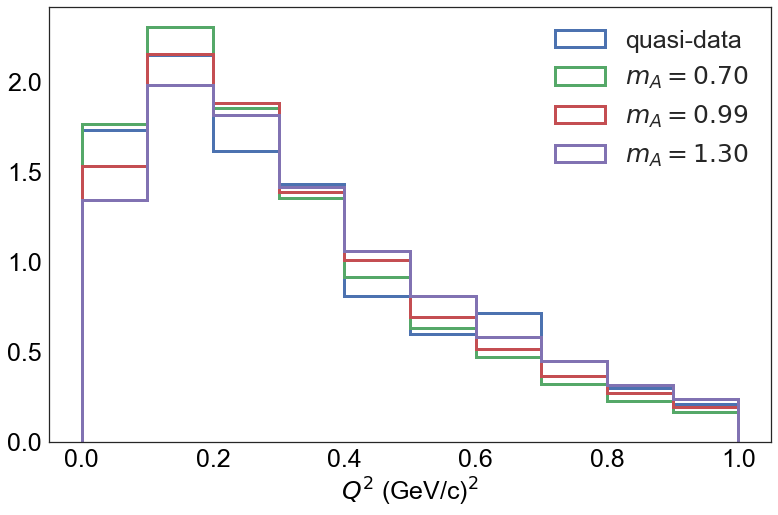

In [26]:
Pval_df = pd.DataFrame(columns={'mA','KS_D','KS_Pval'})
data_array = np.array(quasidata['Q2'])
bins=linspace(0,1,11)
fig,ax=plt.subplots(figsize=(12.944,8));
plt.hist(data_array,bins=bins,normed=1,label='quasi-data',histtype='step',linewidth=3)

for mA in [0.7,0.99,1.3]:#mA_array:
    genie_array = np.array(genie_CC1p0pi[mA]['Q2'])    
    plt.hist(genie_array,bins=bins,normed=1,label='$m_A=%.2f$'%mA,histtype='step',linewidth=3)

    KS_D,KS_Pval = stats.ks_2samp(genie_array, data_array)
    Pval_df = Pval_df.append(pd.DataFrame({'mA':mA,'KS_D':KS_D,'KS_Pval':KS_Pval},index=[mA]))    
    
set_axes(ax,r'$Q^2$ (GeV/c)$^2$','',do_add_legend=True)
print 'done'
Pval_df

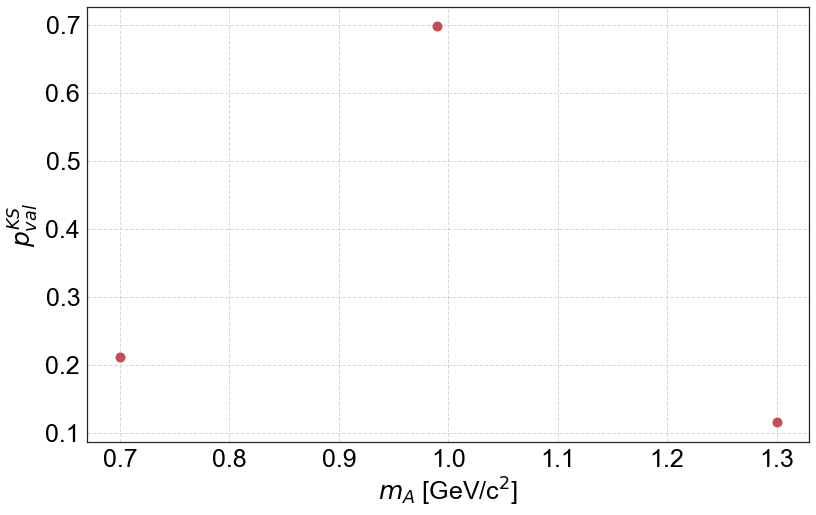

In [27]:
fig,ax=plt.subplots(figsize=(12.944,8))
x,y = Pval_df['mA'] , Pval_df['KS_Pval']
plt.plot( x,y , 'ro',markersize=10,linewidth=2)
set_axes(ax,r'$m_A$ [GeV/c$^2$]','$p_{val}^{KS}$',do_add_grid=True)

In [28]:
#  -- - -- -- - -- - - - - - - - - ---- -- ---- 
# July-05,2018
def weighted_repeat(array, weights, epsilon=1,debug=0):
    '''
    written for KS test using standard (non-weighted) arrays
    
    input:
    array + weights
    
    return:
    repeated array representing the weighted array
    
    '''
    w_min = np.max([epsilon ,np.min(weights)])
    weights_as_repetition_numbers = np.array([np.max([1,int(round(w/w_min))]) for w in weights])
    if debug:
        print 'array:',array
        print 'weights:',weights
        print 'w_min:',w_min
        print 'weights_as_repetition_numbers:',weights_as_repetition_numbers
    repeated_array = np.repeat(array, weights_as_repetition_numbers, axis=0)
    if debug:
        print 'repeated_array:',repeated_array

    return repeated_array
#  -- - -- -- - -- - - - - - - - - ---- -- ---- 


In [29]:
from scipy.stats import distributions

done.


,KS_D,KS_Pval,mA,my_Pval
0.70,0.125594,0.0,0.70,0.000031
0.99,0.095707,0.0,0.99,0.003211
1.30,0.063422,0.0,1.30,0.118263


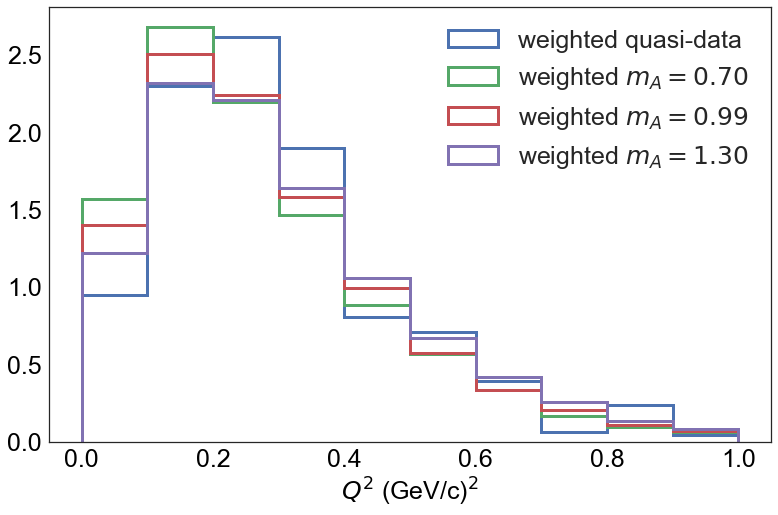

In [30]:
Nquasidata = 350 
quasidata = genie_CC1p0pi[0.99].sample(n=Nquasidata)
data_array = np.array(quasidata['Q2'])
data_weights = np.array(quasidata['MicroBooNEWeight_Pmu_theta_Pp_theta'])
repeated_data = weighted_repeat(data_array, data_weights,debug=0) 

bins=linspace(0,1,11)
fig,ax=plt.subplots(figsize=(12.944,8));
plt.hist(repeated_data,bins=bins,normed=1,label='weighted quasi-data',histtype='step',linewidth=3)

Pval_df = pd.DataFrame(columns={'mA','KS_D','KS_Pval','my_Pval'})
for mA in [0.7,0.99,1.3]: #mA_array:
    
    genie_array = np.array(genie_CC1p0pi[mA]['Q2'])
    genie_weights = np.array(genie_CC1p0pi[mA]['MicroBooNEWeight_Pmu_theta_Pp_theta'])    
    repeated_genie = weighted_repeat(genie_array, genie_weights,debug=0) 

    plt.hist(repeated_genie,bins=bins,normed=1,label='weighted $m_A=%.2f$'%mA,histtype='step',linewidth=3)
    
    KS_D,KS_Pval = stats.ks_2samp(repeated_genie, repeated_data)
    # we do not take standard KS_Pval,
    # as we want to compute the Pval for size n,
    # n-being the real number of events, not the repeated-array size...
    n1 = len(data_array);n2 = len(genie_array)
    en = np.sqrt(n1 * n2 / float(n1 + n2))
    my_Pval = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * KS_D)
        
    Pval_df = Pval_df.append(pd.DataFrame({'mA':mA,'KS_D':KS_D,'KS_Pval':KS_Pval,'my_Pval':my_Pval},index=[mA]))    
    
set_axes(ax,r'$Q^2$ (GeV/c)$^2$','',do_add_legend=True)
print 'done.'
Pval_df

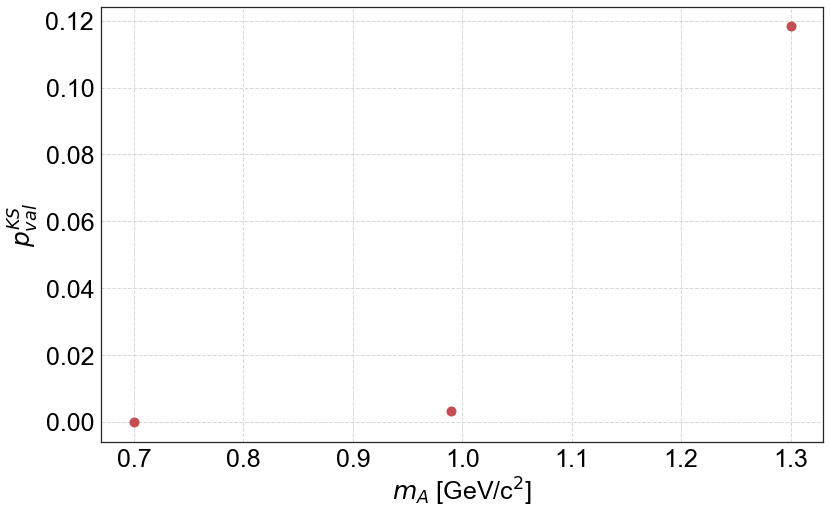

In [31]:
fig,ax=plt.subplots(figsize=(12.944,8))
x,y = Pval_df['mA'] , Pval_df['my_Pval']
plt.plot( x,y , 'ro',markersize=10,linewidth=2)
set_axes(ax,r'$m_A$ [GeV/c$^2$]','$p_{val}^{KS}$',do_add_grid=True)


# Now try to run the same for comparing the overlay to the GENIE distributions

In [32]:
selected_overlay=dict()
for pair_type in pair_types:
    selected_overlay[pair_type]=pd.read_csv('/Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/SelectedEvents/selected_'+pair_type+'.csv')
selected_CC1p0pi=pd.read_csv('/Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/SelectedEvents/selected_cc1p0pi.csv')
selected_events=pd.read_csv('/Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/SelectedEvents/selected_events.csv')
print len(pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])),'events in the overlay'
print len(selected_CC1p0pi),'selected CC 1p 0pi pairs in overlay'

9384 events in the overlay
7304 selected CC 1p 0pi pairs in overlay


In [33]:
# tight FV
max_FV_y = 104 
min_FV_z,max_FV_z = 5,1020
min_FV_x,max_FV_x = 5,240

selected_overlay_tightFV=dict()
for pair_type in pair_types:
    selected_overlay_tightFV[pair_type] = sample_in_FV(selected_overlay[pair_type]
                                                       ,max_FV_y = max_FV_y ,min_FV_z = min_FV_z, max_FV_z = max_FV_z,min_FV_x = min_FV_x, max_FV_x = max_FV_x)
overlay_tightFV = pd.concat([selected_overlay_tightFV['1mu-1p'],selected_overlay_tightFV['cosmic'],selected_overlay_tightFV['other pairs']])
print len(overlay_tightFV),'events in the overlay'

print len(selected_overlay_tightFV),'selected overlay in tight FV'
selected_CC1p0pi_tightFV = sample_in_FV(sample=selected_CC1p0pi
                                   ,max_FV_y = max_FV_y ,min_FV_z = min_FV_z, max_FV_z = max_FV_z,min_FV_x = min_FV_x, max_FV_x = max_FV_x)
print len(selected_CC1p0pi_tightFV),'selected CC1p0π in overlay in tight FV'
selected_events_tightFV = sample_in_FV(sample=selected_events
                                   ,max_FV_y = max_FV_y ,min_FV_z = min_FV_z, max_FV_z = max_FV_z,min_FV_x = min_FV_x, max_FV_x = max_FV_x)
print len(selected_events_tightFV),'selected pairs in data in tight FV'

5294 events in the overlay
4 selected overlay in tight FV
4064 selected CC1p0π in overlay in tight FV
182 selected pairs in data in tight FV


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


done.


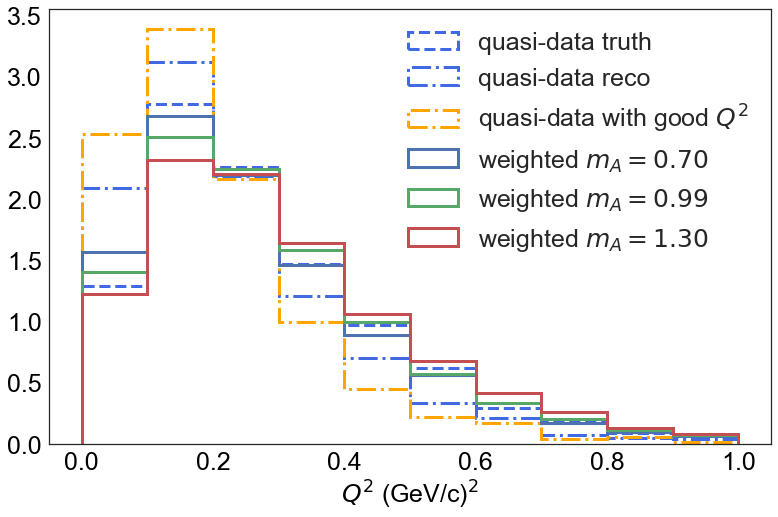

In [47]:
quasidata = selected_CC1p0pi_tightFV
quasidata['corrected_Q2'] = quasidata['reco_Q2'] + 0.049
quasidata_array = np.array(quasidata['corrected_Q2'])

bins=linspace(0,1,11)
fig,ax=plt.subplots(figsize=(12.944,8));
plt.hist(np.array(quasidata['truth_Q2']),bins=bins,normed=1,label='quasi-data truth',histtype='step',linewidth=3,color='royalblue',linestyle='--')
plt.hist(np.array(quasidata['reco_Q2']),bins=bins,normed=1,label='quasi-data reco',histtype='step',linewidth=3,color='royalblue',linestyle='-.')
quasidata_good_Q2 = quasidata[np.abs(quasidata['reco_Q2']-quasidata['truth_Q2'])<0.01]
plt.hist(np.array(quasidata_good_Q2['reco_Q2']),bins=bins,normed=1,label='quasi-data with good $Q^2$',histtype='step',linewidth=3,color='orange',linestyle='-.')
for mA in [0.7,0.99,1.3]: 
    genie_array = np.array(genie_CC1p0pi[mA]['Q2'])
    genie_weights = np.array(genie_CC1p0pi[mA]['MicroBooNEWeight_Pmu_theta_Pp_theta'])    
    plt.hist(genie_array,weights=genie_weights,bins=bins,normed=1,label='weighted $m_A=%.2f$'%mA,histtype='step',linewidth=3)    
set_axes(ax,r'$Q^2$ (GeV/c)$^2$','',do_add_legend=True)
print 'done.'

In [ ]:
quasidata['corrected_Q2'] = quasidata['reco_Q2'] + 0.049
quasidata_array = np.array(quasidata['corrected_Q2'])

bins=linspace(0,1,11)
fig,ax=plt.subplots(figsize=(12.944,8));
plt.hist(np.array(quasidata['truth_Q2']),bins=bins,normed=1,label='quasi-data truth',histtype='step',linewidth=3,color='royalblue',linestyle='--')
plt.hist(np.array(quasidata['reco_Q2']),bins=bins,normed=1,label='quasi-data reco',histtype='step',linewidth=3,color='royalblue',linestyle='-.')
# plt.hist(np.array(quasidata['corrected_Q2']),bins=bins,normed=1,label='quasi-data corrected',histtype='step',linewidth=3,color='royalblue',linestyle='-')

# quasidata_good_Pmu = quasidata[np.abs(quasidata['reco_Pmu']-quasidata['truth_Pmu'])<0.05]
quasidata_good_Q2 = quasidata[np.abs(quasidata['reco_Q2']-quasidata['truth_Q2'])<0.01]
plt.hist(np.array(quasidata_good_Q2['reco_Q2']),bins=bins,normed=1,label='quasi-data with good $Q^2$',histtype='step',linewidth=3,color='orange',linestyle='-.')


Pval_df = pd.DataFrame(columns={'mA','KS_D','KS_Pval','my_Pval'})
for mA in [0.7,0.99,1.3]: #mA_array:
    
    genie_array = np.array(genie_CC1p0pi[mA]['Q2'])
    genie_weights = np.array(genie_CC1p0pi[mA]['MicroBooNEWeight_Pmu_theta_Pp_theta'])    
    repeated_genie = weighted_repeat(genie_array, genie_weights,debug=0) 

    plt.hist(repeated_genie,bins=bins,normed=1,label='weighted $m_A=%.2f$'%mA,histtype='step',linewidth=3)
    
#     KS_D,KS_Pval = stats.ks_2samp(repeated_genie, quasidata_array)
#     # we do not take standard KS_Pval,
#     # as we want to compute the Pval for size n,
#     # n-being the real number of events, not the repeated-array size...
#     n1 = len(data_array);n2 = len(genie_array)
#     en = np.sqrt(n1 * n2 / float(n1 + n2))
#     my_Pval = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * KS_D)

    
#     Pval_df = Pval_df.append(pd.DataFrame({'mA':mA,'KS_D':KS_D,'KS_Pval':KS_Pval,'my_Pval':my_Pval},index=[mA]))    
    
set_axes(ax,r'$Q^2$ (GeV/c)$^2$','',do_add_legend=True)
print 'done.'
# Pval_df

done.


,KS_D,KS_Pval,mA,my_Pval
0.70,0.100476,7.627838e-27,0.70,0.001680
0.99,0.080627,1.944617e-17,0.99,0.020789
1.30,0.079877,4.017273e-17,1.30,0.022541


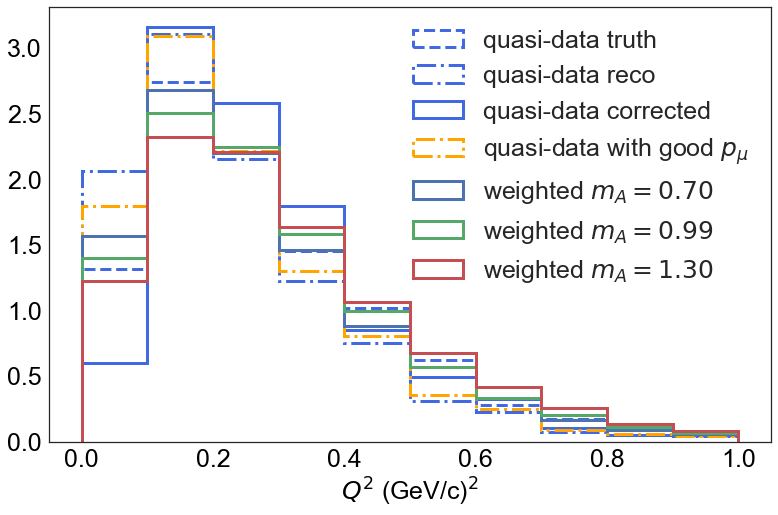

In [36]:
Nquasidata = 3000
quasidata = selected_CC1p0pi_tightFV.sample(n=Nquasidata)
quasidata['corrected_Q2'] = quasidata['reco_Q2'] + 0.049
quasidata_array = np.array(quasidata['corrected_Q2'])

bins=linspace(0,1,11)
fig,ax=plt.subplots(figsize=(12.944,8));
plt.hist(np.array(quasidata['truth_Q2']),bins=bins,normed=1,label='quasi-data truth',histtype='step',linewidth=3,color='royalblue',linestyle='--')
plt.hist(np.array(quasidata['reco_Q2']),bins=bins,normed=1,label='quasi-data reco',histtype='step',linewidth=3,color='royalblue',linestyle='-.')
plt.hist(np.array(quasidata['corrected_Q2']),bins=bins,normed=1,label='quasi-data corrected',histtype='step',linewidth=3,color='royalblue',linestyle='-')
quasidata_good_Pmu = quasidata[np.abs(quasidata['reco_Pmu']-quasidata['truth_Pmu'])<0.1]
plt.hist(np.array(quasidata_good_Pmu['reco_Q2']),bins=bins,normed=1,label='quasi-data with good $p_\mu$',histtype='step',linewidth=3,color='orange',linestyle='-.')


Pval_df = pd.DataFrame(columns={'mA','KS_D','KS_Pval','my_Pval'})
for mA in [0.7,0.99,1.3]: #mA_array:
    
    genie_array = np.array(genie_CC1p0pi[mA]['Q2'])
    genie_weights = np.array(genie_CC1p0pi[mA]['MicroBooNEWeight_Pmu_theta_Pp_theta'])    
    repeated_genie = weighted_repeat(genie_array, genie_weights,debug=0) 

    plt.hist(repeated_genie,bins=bins,normed=1,label='weighted $m_A=%.2f$'%mA,histtype='step',linewidth=3)
    
    KS_D,KS_Pval = stats.ks_2samp(repeated_genie, quasidata_array)
    # we do not take standard KS_Pval,
    # as we want to compute the Pval for size n,
    # n-being the real number of events, not the repeated-array size...
    n1 = len(data_array);n2 = len(genie_array)
    en = np.sqrt(n1 * n2 / float(n1 + n2))
    my_Pval = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * KS_D)

    
    Pval_df = Pval_df.append(pd.DataFrame({'mA':mA,'KS_D':KS_D,'KS_Pval':KS_Pval,'my_Pval':my_Pval},index=[mA]))    
    
set_axes(ax,r'$Q^2$ (GeV/c)$^2$','',do_add_legend=True)
print 'done.'
Pval_df

0.0137632


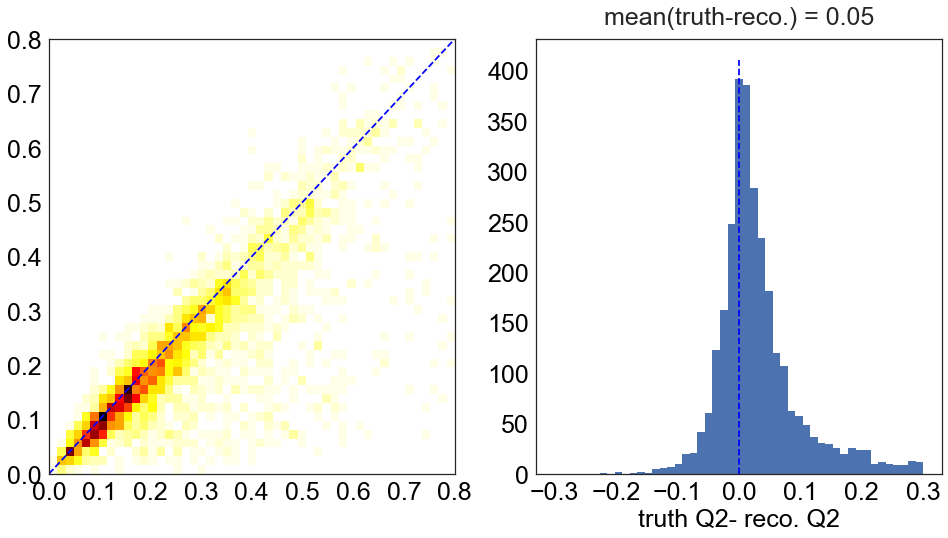

In [37]:
fig = plt.figure(figsize=(16,8))

ax=fig.add_subplot(1,2,1)
plot_2d_hist(quasidata['closest_genie_Q2'],quasidata['reco_Q2'],bins=linspace(0,0.8,50),ax=ax);
plt.plot([0,0.8],[0,0.8],'--',color='blue')

ax=fig.add_subplot(1,2,2)
plt.hist(quasidata['closest_genie_Q2']-quasidata['reco_Q2'],bins=linspace(-0.3,0.3,50));
plt.plot([0,0],ax.get_ylim(),'--',color='blue')

print np.min(quasidata['closest_genie_Q2'])
mean = np.mean(quasidata['closest_genie_Q2']-quasidata['reco_Q2'])

set_axes(ax,x_label=('truth Q2- reco. Q2'),y_label=''
             ,title='mean(truth-reco.) = %.2f'%mean)



# plot_2d_hist(quasidata['truth_Ev'],quasidata['reco_Ev'],bins=linspace(0.2,1.2,50)
#              ,xlabel='truth_Ev',ylabel='reco_Ev');
# plt.plot([0,2],[0,2],'--',color='blue')
# plot_2d_hist(quasidata['truth_Xb'],quasidata['reco_Xb'],bins=linspace(0,2,50));
# plt.plot([0,2],[0,2],'--',color='blue')

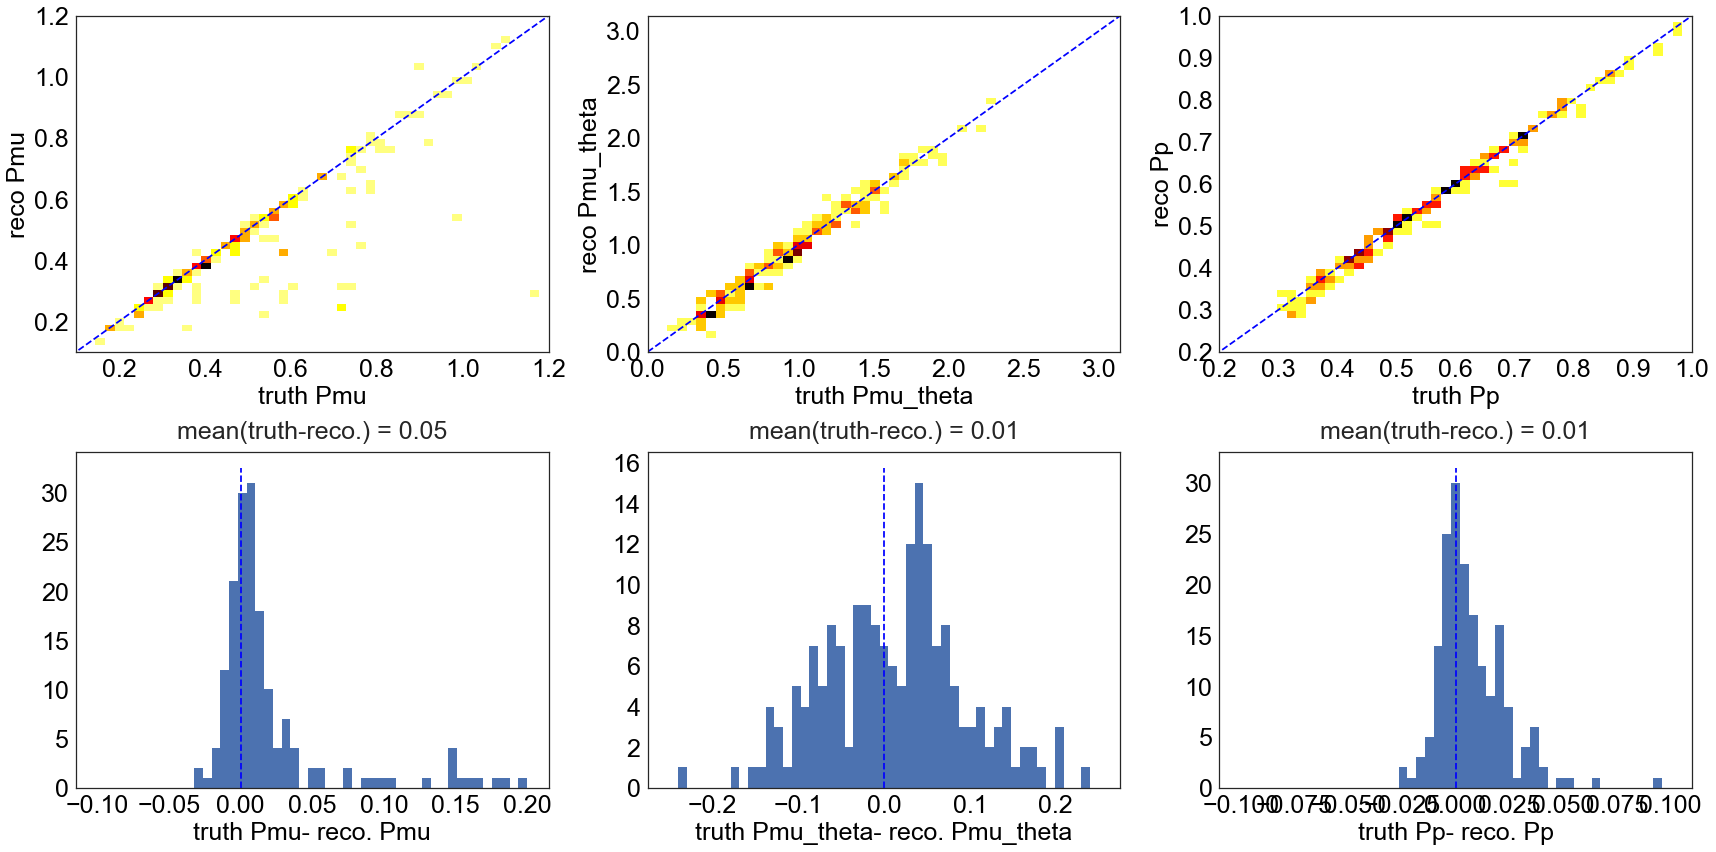

In [20]:
fig = plt.figure(figsize=(24,12))
for i,(var,bins,xlim) in enumerate(zip(['Pmu','Pmu_theta','Pp']
                                  ,[linspace(0.1,1.2,50),linspace(0,np.pi,50),linspace(0.2,1,50)]
                                       ,[(-0.1,0.2),(-0.25,0.25),(-0.1,0.1)])):
    ax=fig.add_subplot(2,3,i+1)
    plot_2d_hist(quasidata['truth_'+var],quasidata['reco_'+var],bins=bins,ax=ax
                 ,xlabel='truth '+var,ylabel='reco '+var);
    plt.plot([0,np.max(bins)],[0,np.max(bins)],'--',color='blue')
    
    ax=fig.add_subplot(2,3,i+4)
    plt.hist(quasidata['truth_'+var]-quasidata['reco_'+var],bins=linspace(xlim[0],xlim[1],50));
    plt.plot([0,0],ax.get_ylim(),'--',color='blue')
    mean = np.mean(quasidata['truth_'+var]-quasidata['reco_'+var])    
    set_axes(ax,x_label=('truth '+var+'- reco. ' +var),y_label=''
             ,title='mean(truth-reco.) = %.2f'%mean)



plt.tight_layout()

0.0496538688853
0.0571586578248
0.0186035034058


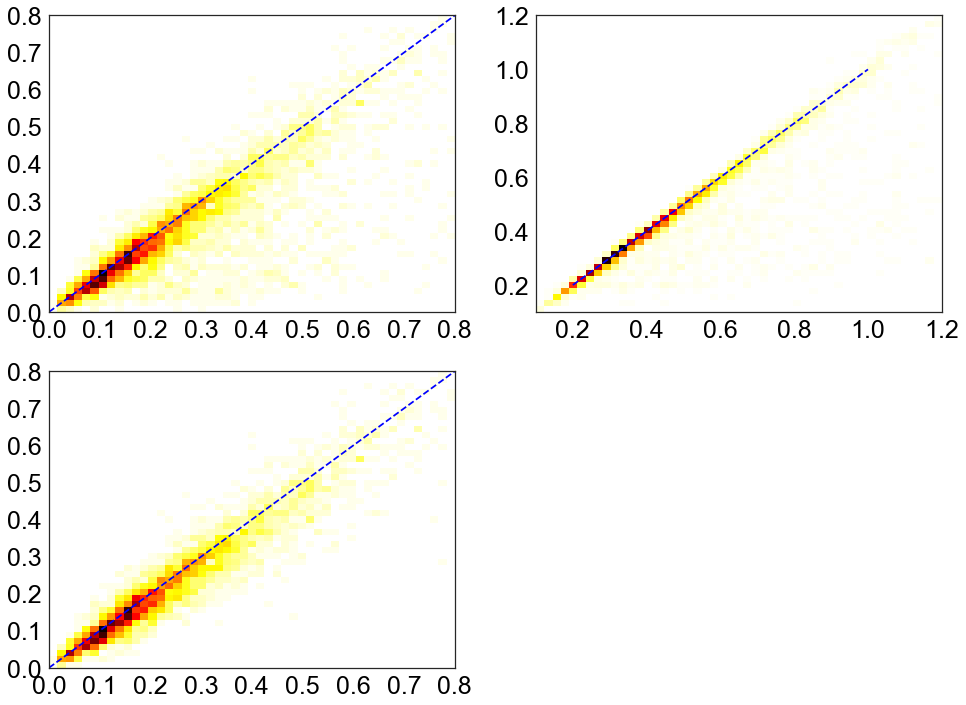

In [40]:

fig = plt.figure(figsize=(16,12))
ax=fig.add_subplot(2,2,1)
plot_2d_hist(selected_CC1p0pi_tightFV['closest_genie_Q2'],selected_CC1p0pi_tightFV['reco_Q2'],bins=linspace(0.,.8,50),ax=ax);
mean = np.mean(selected_CC1p0pi_tightFV['closest_genie_Q2']-selected_CC1p0pi_tightFV['reco_Q2'])    
print mean
plt.plot([0,0.8],[0,0.8],'--',color='blue')

ax=fig.add_subplot(2,2,2)
plot_2d_hist(selected_CC1p0pi_tightFV['truth_Pmu'],selected_CC1p0pi_tightFV['reco_Pmu'],bins=linspace(0.1,1.2,50),ax=ax);
mean = np.mean(selected_CC1p0pi_tightFV['truth_Pmu']-selected_CC1p0pi_tightFV['reco_Pmu'])    
print mean
plt.plot([0.2,1],[0.2,1],'--',color='blue')


# mean = np.mean(selected_CC1p0pi_tightFV['truth_Pp']-selected_CC1p0pi_tightFV['reco_Pp'])    
# print mean

ax=fig.add_subplot(2,2,3)
selected_CC1p0pi_good_Pmu = selected_CC1p0pi_tightFV[np.abs(selected_CC1p0pi_tightFV['reco_Pmu']-selected_CC1p0pi_tightFV['truth_Pmu'])<0.1]
plot_2d_hist(selected_CC1p0pi_good_Pmu['closest_genie_Q2'],selected_CC1p0pi_good_Pmu['reco_Q2'],bins=linspace(0.,.8,50),ax=ax);
mean = np.mean(selected_CC1p0pi_good_Pmu['closest_genie_Q2']-selected_CC1p0pi_good_Pmu['reco_Q2'])    
print mean
plt.plot([0,0.8],[0,0.8],'--',color='blue')



